Tensorflwo 2.X recomments using high level API such as tf.keras but leaves the low lel API's typical as of TF 1.x when there is need  to have more control over the internal details.


### Eager Execution

Tf 1.x defines static computationnal graph, this type odf declarative programming was confusing for many people.Python has dynamic approach of programming so following that, pytorch a New deep learning frameworl, defines thinggs in more imperativ enad dynamic way, but still you can have graph,you can define,change, execute nodes easily but with nospecial sessions or palceholders like in TF 1.x. This is called eager execution, meaning model definitiosna re dynamic and execution is immediate. Graphs and Sessons are considered as implementation details

Both pytorch and tensorflow 2 styles are inherited from Chainer, a frame for Neural Networks (https://chainer.org)

the good news is Tesnorflow supports Eager Execution

## Autograph

TF 2.x also supports imperative python code including if-while, print(), and other python natove features, and can natively covert in into pure Tensorflow graph code.
Autograph takes eager stype pyton code and automatically converts into graph generating code.

Using Autograph is extremely easy, the only thing you need to do is annotate your python code with special decorator, tf.fucntion as in the example below

In [32]:
import tensorflow as tf
import pydot
import graphviz
def linear_layer(x):
    
    return 3*x +2
@tf.function
def simple_nn(x):
    return tf.nn.relu(linear_layer(x))

def simple_function(x):
    return 3*x



If we inspect hte simple_nn. we can see that it is a special handler for intereacting with TF internal, while simple_function is a normal python handler

In [2]:
simple_nn

In [4]:
simple_function

<function __main__.simple_function(x)>

Note that tf.fucntion you need to annotate only main function, so all other function called from there will be automatically and transparently transformed into computational graph.
For example no need to annotate linear-layer

Internal look at autogenerated code

In [6]:
print(tf.autograph.to_code(simple_nn.python_function, experimental_optional_features=None))

def tf__simple_nn(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('simple_nn', 'simple_nn_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as simple_nn_scope:
    do_return = True
    retval_ = simple_nn_scope.mark_return_value(ag__.converted_call(tf.nn.relu, simple_nn_scope.callopts, (ag__.converted_call(linear_layer, simple_nn_scope.callopts, (x,), None, simple_nn_scope),), None, simple_nn_scope))
  do_return,
  return ag__.retval(retval_)



lets compare the spped of execiton of code , annoated b tf.fucntion and not annotated by tf.fucntion

In [7]:
import tensorflow as tf
import timeit

In [10]:
cell = tf.keras.layers.LSTMCell(100)

@tf.function
def fn(input, state):
    return cell(input, state)

input = tf.zeros([100,100])

state = [tf.zeros([100,100])] *2

cell(input, state)
fn(input, state)

graph_time = timeit.timeit(lambda: cell(input, state), number=100)
auto_graph_time = timeit.timeit(lambda: fn(input, state), number=100)

print('graph_time:', graph_time)
print('Auto graph time:', auto_graph_time)

graph_time: 0.6134280790001867
Auto graph time: 0.09872611299942946


When the code fragment is excuted, we can see the reductoion in time. You cna decoare any python fucntio and methods with tf.function which converts them to equivalent graph, with all optimization that comes with it.

# Keras APIs

1. Sequention API
2. Functional API
3. Model Subclassing

1. Sequential API

Previously  we used sequeuantl API which works for amost 90% of the cases, layer is added in sequential order which is easy and intuitive to uderstand

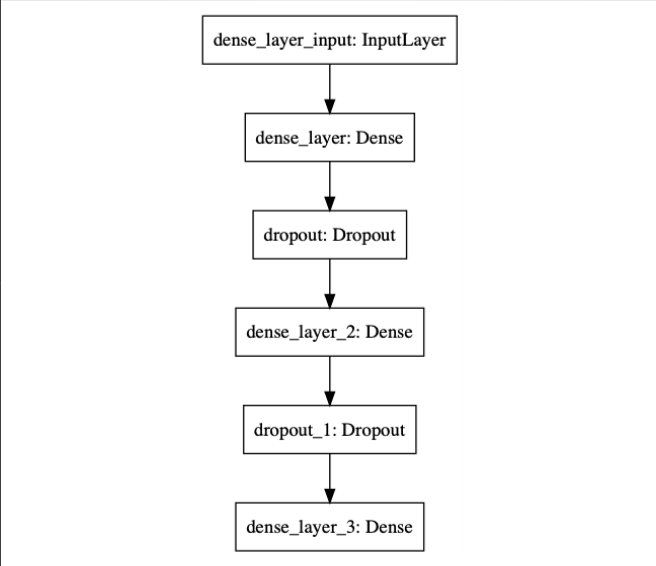

## Functional API

Functional API is used when you want  tobuild  complex model with multiple input  and output, residual connection nad when ther is non-sequential flow

Lets lookk at an example where we have two separate inputs, two logistci regrssion as outputs and one shared module

In [21]:
import tensorflow as tf
def build_model():
    text_input_a = tf.keras.Input(shape=(None,), dtype ='int32')
    
    text_input_b = tf.keras.Input(shape=(None,), dtype ='int32')
    
    shared_embedding = tf.keras.layers.Embedding(1000,128)
    
    encoded_input_a = shared_embedding(text_input_a)
    encoded_input_b = shared_embedding(text_input_b)
    
    #two logistc predictions
    
    prediction_a = tf.keras.layers.Dense(1, activation='sigmoid', name='prediction_a')(encoded_input_a)
    prediction_b = tf.keras.layers.Dense(1, activation='sigmoid', name='prediction_b')(encoded_input_b)
    
    # the model has two inputs an and two outputs
    
    model  = tf.keras.Model(inputs=[text_input_a, text_input_b],outputs= [[prediction_a, prediction_b]])
    
    tf.keras.utils.plot_model(model, to_file='shared_model.png')
    
    

In [31]:
build_model()

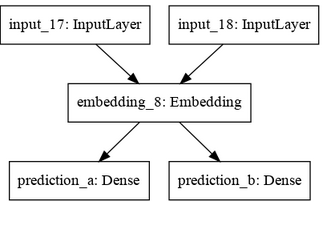

Note that, first, we create a layer, then you pass it an input; with tf.keras.layers.Dense(1, activation='sigmoid', name='prediction_a')(encoded_input_a)the two steps are combined in a single line of code.

## Model Subclassing

Model subclassing offers the highest flexibility and it is generally used when you need to define your own layer.

So, in order to create a custom layer, we can subclass tf.keras.layers.Layer and implement the following methods

• __init__: Optionally used to define all the sublayers to be used by this layer. This is the constructor where you can declare your model.

• build: Used to create the weights of the layer. we can add weights with add_weight().

• call: Used to define the forward pass. This is where layer is called and chained in functional style.



In [40]:
from keras import layers
class MyLayer(layers.Layer): 
    
    def __init__(self, output_dim, **kwargs):
        
        self.output_dim = output_dim  
        super(MyLayer, self).__init__(**kwargs) 
        
    def build(self, input_shape):    
        self.kernel = self.add_weight(name='kernel',        
                                    shape=(input_shape[1], self.output_dim),   
                                    initializer='uniform',    
                                    trainable=True)  
    def call(self, inputs):
        
        # Do the multiplication and return 
        return tf.matmul(inputs, self.kernel)

In [42]:
model = tf.keras.Sequential()([
    MyLayer(20),
    layers.Activation('softmax')])

We saw three Keras APIs, we  wil be using all of them later.